In [1]:
import os
import pickle
import csv
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, LSTM, Dense, Flatten, TimeDistributed, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm

In [2]:
def load_audio_data(tsv_path, audio_dir, sample_rate=16000, duration=1, top_db=20):
    audio_data = []
    labels = []
    label_mapping = {}
    max_length = sample_rate * duration
    other_labels = ['huit', 'zÃ©ro', 'Firefox', 'sept', 'cinq', 'neuf', 'Hey', 'six']

    with open(tsv_path, "r") as tsv_file:
        tsv_reader = csv.DictReader(tsv_file, delimiter="\t")
        
        for row in tqdm(tsv_reader, desc="Chargement des données audio", unit="audio"):
            audio_path = os.path.join(audio_dir, row["path"])
            signal, _ = librosa.load(audio_path, sr=sample_rate, duration=duration)
            signal, _ = librosa.effects.trim(signal, top_db=top_db)
            
            if len(signal) < max_length:
                signal = np.pad(signal, (0, max_length - len(signal)))
            else:
                signal = signal[:max_length]

            mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)
            audio_data.append(mfcc)
            if row["sentence"] not in other_labels:
                labels.append(label_mapping.setdefault(row["sentence"], len(label_mapping)))
            else:
                labels.append(label_mapping.setdefault('other', len(label_mapping)))
            
    return np.array(audio_data), np.array(labels), label_mapping

In [3]:
def load_audio_labels(tsv_path):
    word_bag = {}
    
    with open(tsv_path, "r") as tsv_file:
        tsv_reader = csv.DictReader(tsv_file, delimiter="\t")
        
        for row in tqdm(tsv_reader, desc="Chargement des labels "):
            if row["sentence"] not in other_labels:
                label = row["sentence"]
            else:
                label = 'other'
            if label not in word_bag:
                word_bag[label] = len(word_bag)
            
    return word_bag

In [4]:
def augment_audio_data(X, y, start_multiple=0, sample_rate=16000, percentage=1.0):
    assert 0 <= percentage <= 1, "Percentage should be between 0 and 1"
    
    num_samples = int(len(X) * percentage)
    indices = np.random.choice(len(X), num_samples, replace=False)
    
    augmented_data = []
    augmented_labels = []
    pickle_step = 100
    pickle_file_template = "augmented_pickles/augmented_audio_features_{}.pkl"

    for i, index in enumerate(tqdm(indices, total=num_samples, desc="Augmenting data")):
        if i < start_multiple * pickle_step:
            continue

        mfcc = X[index]
        label = y[index]

        # Modifiez légèrement la vitesse du signal
        for rate in [0.9, 1.1]:
            stretched_mfcc = librosa.feature.inverse.mfcc_to_audio(mfcc)
            y_stft = librosa.stft(stretched_mfcc)
            y_stft_fast = librosa.core.phase_vocoder(y_stft, rate=rate)
            stretched_signal = librosa.istft(y_stft_fast)
            
            new_mfcc = librosa.feature.mfcc(y=stretched_signal, sr=sample_rate, n_mfcc=13)
            mfcc_padded = np.zeros_like(mfcc)
            mfcc_padded[:, :min(new_mfcc.shape[1], mfcc_padded.shape[1])] = new_mfcc[:, :mfcc_padded.shape[1]]
            augmented_data.append(mfcc_padded)
            augmented_labels.append(label)

        if (i + 1) % pickle_step == 0:
            pickle_file = pickle_file_template.format(i // pickle_step)
            with open(pickle_file, "wb") as f:
                pickle.dump((augmented_data, augmented_labels), f)
            augmented_data = []
            augmented_labels = []

    X_augmented = np.array(augmented_data)
    y_augmented = np.array(augmented_labels)
    return X_augmented, y_augmented


In [5]:
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    
    return model


In [6]:
pickle_file = "audio_features_other.pkl"
tsv_path = "./cv-corpus-7.0-singleword/fr/validated.tsv"
audio_dir = "./cv-corpus-7.0-singleword/fr/clips"
other_labels = ['huit', 'zÃ©ro', 'Firefox', 'sept', 'cinq', 'neuf', 'Hey', 'six']


if os.path.exists(pickle_file):
    with open(pickle_file, "rb") as f:
        X, y = pickle.load(f)

    label_mapping = load_audio_labels(tsv_path)
else:
    X, y, label_mapping = load_audio_data(tsv_path, audio_dir, top_db=10, duration=2)

    # Enregistrez les données dans un fichier pickle
    with open(pickle_file, "wb") as f:
        pickle.dump((X, y), f)


Chargement des labels : 20017it [00:00, 101838.37it/s]


In [7]:
pickle_labels_file = "class_labels_other.pkl"

if os.path.exists(pickle_labels_file):
    # Load class labels from the pickle file
    with open(pickle_labels_file, "rb") as f:
        class_labels = pickle.load(f)
else:
    # Find the class labels
    class_labels = {v: k for k, v in label_mapping.items()}

    # Save class labels in a pickle file
    with open(pickle_labels_file, "wb") as f:
        pickle.dump(class_labels, f)

# Print class labels
print("Class Labels:")
for key, value in class_labels.items():
    print(f"{key} : {value}")

Class Labels:
0 : other
1 : trois
2 : quatre
3 : un
4 : non
5 : oui
6 : deux


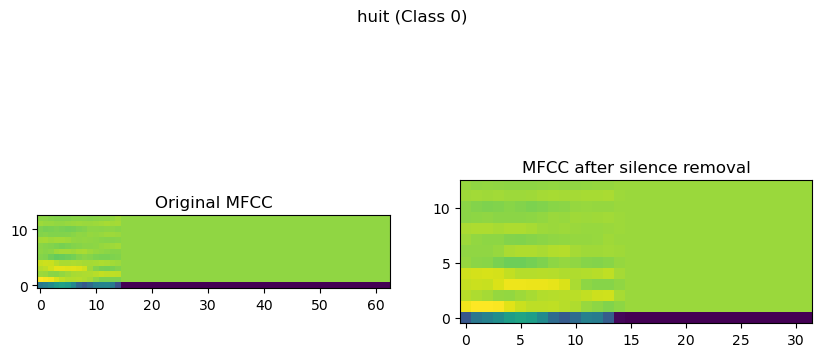

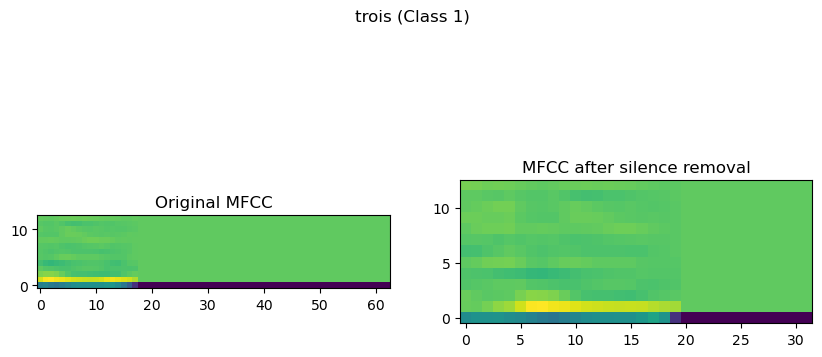

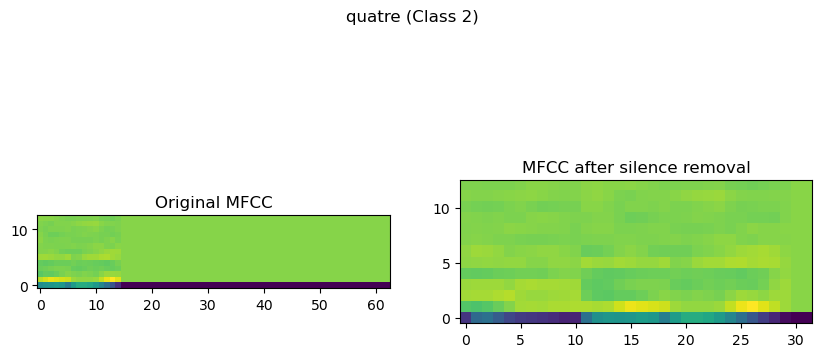

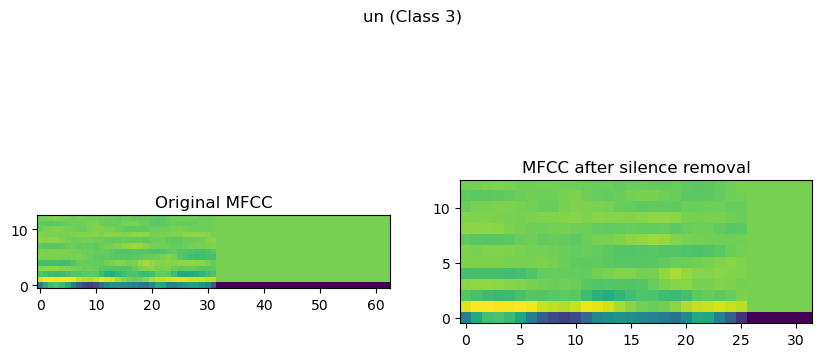

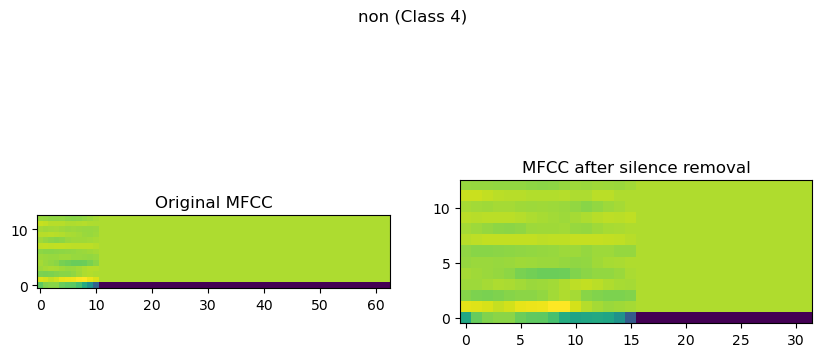

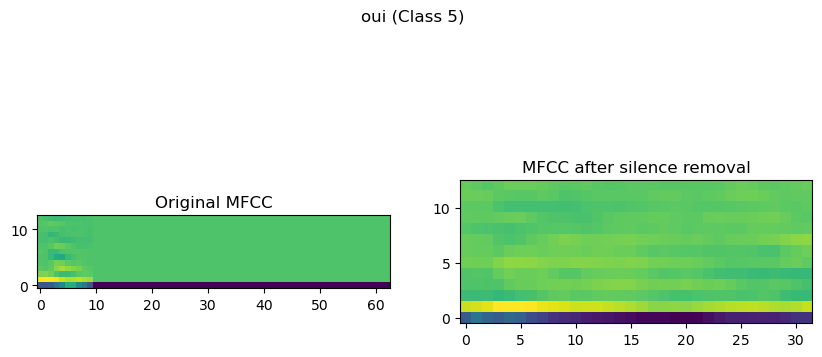

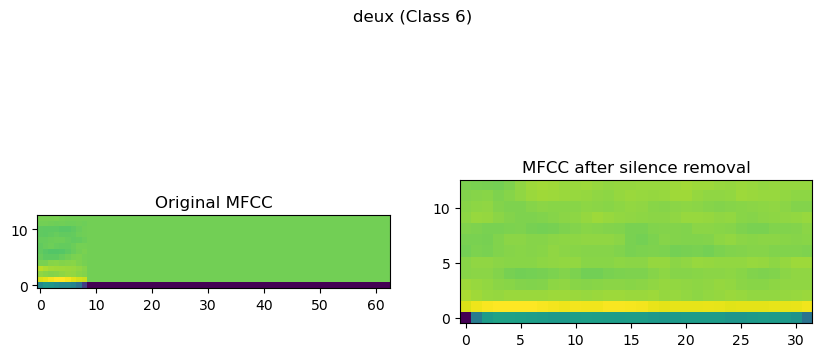

In [8]:
import matplotlib.pyplot as plt

def plot_mfccs(mfcc_before, mfcc_after, title_prefix, index):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"{title_prefix} (Class {index})")

    axes[0].imshow(mfcc_before, cmap="viridis", origin="lower")
    axes[0].set_title("Original MFCC")

    axes[1].imshow(mfcc_after, cmap="viridis", origin="lower")
    axes[1].set_title("MFCC after silence removal")

    plt.show()


def plot_mfccs_for_classes(X, y, label_data):
    sample_rate = 16000
    duration = 1
    max_length = sample_rate * duration
    top_db = 20
    num_classes = len(np.unique(y))

    for i in range(num_classes):
        index = np.where(y == i)[0][0]
        mfcc_before = X[index]
        label = label_data[index]

        audio_path = os.path.join(audio_dir, label["path"])
        signal, _ = librosa.load(audio_path, sr=sample_rate, duration=duration)
        signal, _ = librosa.effects.trim(signal, top_db=top_db)

        if len(signal) < max_length:
            signal = np.pad(signal, (0, max_length - len(signal)))
        else:
            signal = signal[:max_length]

        mfcc_after = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)

        plot_mfccs(mfcc_before, mfcc_after, label["sentence"], i)
        
# Load label_data from the tsv file
label_data = []
with open(tsv_path, "r") as tsv_file:
    tsv_reader = csv.DictReader(tsv_file, delimiter="\t")
    label_data = [row for row in tsv_reader]

plot_mfccs_for_classes(X, y, label_data)


In [9]:
# Set the start_multiple to the desired multiple of 100 to start the augmentation process
start_multiple = 0

pickle_directory = "augmented_pickles_autre"
if not os.path.exists(pickle_directory):
    os.makedirs(pickle_directory)

#X_augmented, y_augmented = augment_audio_data(X, y, start_multiple=start_multiple)

X_augmented_total = []
y_augmented_total = []
i = 0

while True:
    pickle_file = os.path.join(pickle_directory, "augmented_audio_features_{}.pkl".format(i))
    if not os.path.exists(pickle_file):
        break

    with open(pickle_file, "rb") as f:
        X_part, y_part = pickle.load(f)
        X_augmented_total.extend(X_part)
        y_augmented_total.extend(y_part)
    
    i += 1

X_augmented_total = np.array(X_augmented_total)
y_augmented_total = np.array(y_augmented_total)


In [10]:
X = X[..., np.newaxis]  # Ajoutez une dimension pour correspondre à l'entrée CNN
num_classes = len(np.unique(y))  # Obtenez le nombre total de classes
y = to_categorical(y, num_classes=num_classes)  # Convertissez les labels en one-hot encoding

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train[0].shape

(13, 63, 1)

In [13]:
input_shape = X_train[0].shape
model = create_cnn_lstm_model(input_shape, num_classes)

In [14]:
model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

C:\Users\s_has\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


126/126 [==============================] - 2s 10ms/step
Epoch 1: Accuracy = 0.7493, Precision = 0.7463, Recall = 0.7493, F1 = 0.7335
126/126 [==============================] - 2s 15ms/step
Epoch 2: Accuracy = 0.8499, Precision = 0.8520, Recall = 0.8499, F1 = 0.8446
126/126 [==============================] - 2s 14ms/step
Epoch 3: Accuracy = 0.8779, Precision = 0.8838, Recall = 0.8779, F1 = 0.8772
126/126 [==============================] - 2s 12ms/step
Epoch 4: Accuracy = 0.8949, Precision = 0.8950, Recall = 0.8949, F1 = 0.8936
126/126 [==============================] - 2s 13ms/step
Epoch 5: Accuracy = 0.9008, Precision = 0.9018, Recall = 0.9008, F1 = 0.9010
126/126 [==============================] - 2s 13ms/step
Epoch 6: Accuracy = 0.9003, Precision = 0.9033, Recall = 0.9003, F1 = 0.9006
126/126 [==============================] - 2s 16ms/step
Epoch 7: Accuracy = 0.9108, Precision = 0.9118, Recall = 0.9108, F1 = 0.9104
126/126 [==============================] - 2s 14ms/step
Epoch 8: Accu

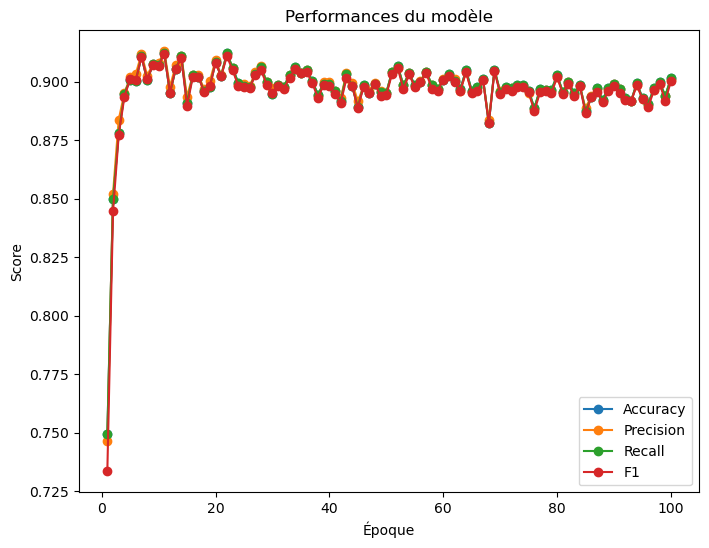

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Liste pour stocker les valeurs des métriques pour chaque époque
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Entraînement du modèle avec boucle sur les époques
for epoch in range(1, 101):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    y_pred = model.predict(X_test)
    
    # Calcul des métriques pour cette époque
    accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    precision = precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted')
    recall = recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted')
    f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted')
    
    # Stockage des valeurs des métriques
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)
    
    print(f"Epoch {epoch}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

# Création du graphe
epochs = range(1, len(accuracy_values) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy_values, marker='o', label='Accuracy')
plt.plot(epochs, precision_values, marker='o', label='Precision')
plt.plot(epochs, recall_values, marker='o', label='Recall')
plt.plot(epochs, f1_values, marker='o', label='F1')
plt.title('Performances du modèle')
plt.xlabel('Époque')
plt.ylabel('Score')
plt.legend()
plt.show()


In [ ]:
#checkpoint = ModelCheckpoint("best_model_autre_v2.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
#early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1)

In [ ]:
#model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

In [ ]:
# Prédire les étiquettes pour les données de test
#y_pred = model.predict(X_test)
#y_pred = np.argmax(y_pred, axis=1)  # Convertir les probabilités en étiquettes de classe

In [ ]:
#from sklearn.metrics import confusion_matrix

# Convert y_test to multiclass format
#y_test_labels = np.argmax(y_test, axis=1)

# Generate confusion matrix
#cm = confusion_matrix(y_test_labels, y_pred)

# Print confusion matrix with labels
#print("Confusion Matrix:")
#print("      ", end=" | ")
#for label in class_labels.values():
    #print(f"{label:<10}", end=" | ")
#print("\n---------------------------------------------------------------------------------------------------")
#for i, row in enumerate(cm):
    #print(f"{list(class_labels.values())[i]:<6}", end=" | ")
    #for count in row:
        #print(f"{count:<10}", end=" | ")
    #print()

In [ ]:
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
#from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate, false_negative_rate

In [ ]:
# Calculer les métriques de performance
#accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
#precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
#recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
#f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')